In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_1:wisig",
    "labels": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "domains_source": [3],
    "domains_target": [1, 2, 4],
    "pickle_name_target": "wisig.node3-19.stratified_ds.2022A.pkl",
    "pickle_name_source": "wisig.node3-19.stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 130}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 420,
    "seed": 420,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 359], examples_per_second: 816.7579, train_label_loss: 4.8461, 


epoch: 1, [batch: 36 / 359], examples_per_second: 11468.9120, train_label_loss: 4.1771, 


epoch: 1, [batch: 72 / 359], examples_per_second: 11732.8317, train_label_loss: 3.6057, 


epoch: 1, [batch: 108 / 359], examples_per_second: 11285.8807, train_label_loss: 3.1089, 


epoch: 1, [batch: 144 / 359], examples_per_second: 11532.4734, train_label_loss: 2.7936, 


epoch: 1, [batch: 180 / 359], examples_per_second: 11498.0186, train_label_loss: 2.3772, 


epoch: 1, [batch: 215 / 359], examples_per_second: 11571.4557, train_label_loss: 2.1631, 


epoch: 1, [batch: 251 / 359], examples_per_second: 11595.7902, train_label_loss: 1.9292, 


epoch: 1, [batch: 287 / 359], examples_per_second: 11631.6253, train_label_loss: 1.7453, 


epoch: 1, [batch: 323 / 359], examples_per_second: 11492.6104, train_label_loss: 1.5795, 


epoch: 1, source_val_acc_label: 0.8535, source_val_label_loss: 1.2905, target_val_acc_label: 0.6052, target_val_label_loss: 2.1053, 


New best
epoch: 2, [batch: 1 / 359], examples_per_second: 115.4732, train_label_loss: 1.4331, 


epoch: 2, [batch: 36 / 359], examples_per_second: 11670.3964, train_label_loss: 1.2666, 


epoch: 2, [batch: 72 / 359], examples_per_second: 11453.7688, train_label_loss: 1.1274, 


epoch: 2, [batch: 108 / 359], examples_per_second: 11544.2456, train_label_loss: 0.8228, 


epoch: 2, [batch: 144 / 359], examples_per_second: 11419.4513, train_label_loss: 0.8595, 


epoch: 2, [batch: 180 / 359], examples_per_second: 11717.1902, train_label_loss: 0.7238, 


epoch: 2, [batch: 215 / 359], examples_per_second: 11604.7148, train_label_loss: 0.6108, 


epoch: 2, [batch: 251 / 359], examples_per_second: 11692.3521, train_label_loss: 0.6982, 


epoch: 2, [batch: 287 / 359], examples_per_second: 11651.4766, train_label_loss: 0.5908, 


epoch: 2, [batch: 323 / 359], examples_per_second: 11610.5162, train_label_loss: 0.5102, 


epoch: 2, source_val_acc_label: 0.9339, source_val_label_loss: 0.5152, target_val_acc_label: 0.6731, target_val_label_loss: 1.6106, 


New best
epoch: 3, [batch: 1 / 359], examples_per_second: 142.4059, train_label_loss: 0.5787, 


epoch: 3, [batch: 36 / 359], examples_per_second: 11361.5985, train_label_loss: 0.4340, 


epoch: 3, [batch: 72 / 359], examples_per_second: 11650.2826, train_label_loss: 0.3666, 


epoch: 3, [batch: 108 / 359], examples_per_second: 11586.9127, train_label_loss: 0.3280, 


epoch: 3, [batch: 144 / 359], examples_per_second: 11674.5189, train_label_loss: 0.3424, 


epoch: 3, [batch: 180 / 359], examples_per_second: 11556.0211, train_label_loss: 0.3076, 


epoch: 3, [batch: 215 / 359], examples_per_second: 11431.0129, train_label_loss: 0.3255, 


epoch: 3, [batch: 251 / 359], examples_per_second: 11696.6190, train_label_loss: 0.4235, 


epoch: 3, [batch: 287 / 359], examples_per_second: 11538.3255, train_label_loss: 0.3509, 


epoch: 3, [batch: 323 / 359], examples_per_second: 11559.7603, train_label_loss: 0.1843, 


epoch: 3, source_val_acc_label: 0.9572, source_val_label_loss: 0.3093, target_val_acc_label: 0.6968, target_val_label_loss: 1.5094, 


New best
epoch: 4, [batch: 1 / 359], examples_per_second: 144.3075, train_label_loss: 0.3160, 


epoch: 4, [batch: 36 / 359], examples_per_second: 11329.5593, train_label_loss: 0.2108, 


epoch: 4, [batch: 72 / 359], examples_per_second: 11327.1008, train_label_loss: 0.2596, 


epoch: 4, [batch: 108 / 359], examples_per_second: 11640.9991, train_label_loss: 0.2387, 


epoch: 4, [batch: 144 / 359], examples_per_second: 11712.7521, train_label_loss: 0.2287, 


epoch: 4, [batch: 180 / 359], examples_per_second: 11318.2189, train_label_loss: 0.3278, 


epoch: 4, [batch: 215 / 359], examples_per_second: 11830.1376, train_label_loss: 0.2421, 


epoch: 4, [batch: 251 / 359], examples_per_second: 11736.5366, train_label_loss: 0.2416, 


epoch: 4, [batch: 287 / 359], examples_per_second: 11667.3234, train_label_loss: 0.2967, 


epoch: 4, [batch: 323 / 359], examples_per_second: 11677.2416, train_label_loss: 0.1870, 


epoch: 4, source_val_acc_label: 0.9549, source_val_label_loss: 0.2377, target_val_acc_label: 0.6918, target_val_label_loss: 1.4793, 


epoch: 5, [batch: 1 / 359], examples_per_second: 147.7355, train_label_loss: 0.1710, 


epoch: 5, [batch: 36 / 359], examples_per_second: 11325.5850, train_label_loss: 0.2209, 


epoch: 5, [batch: 72 / 359], examples_per_second: 11644.6391, train_label_loss: 0.1559, 


epoch: 5, [batch: 108 / 359], examples_per_second: 11637.5084, train_label_loss: 0.1300, 


epoch: 5, [batch: 144 / 359], examples_per_second: 11399.4408, train_label_loss: 0.2439, 


epoch: 5, [batch: 180 / 359], examples_per_second: 11437.2983, train_label_loss: 0.1728, 


epoch: 5, [batch: 215 / 359], examples_per_second: 11452.7156, train_label_loss: 0.1288, 


epoch: 5, [batch: 251 / 359], examples_per_second: 11649.0748, train_label_loss: 0.1297, 


epoch: 5, [batch: 287 / 359], examples_per_second: 11674.2086, train_label_loss: 0.1396, 


epoch: 5, [batch: 323 / 359], examples_per_second: 11559.1243, train_label_loss: 0.1335, 


epoch: 5, source_val_acc_label: 0.9670, source_val_label_loss: 0.1914, target_val_acc_label: 0.7038, target_val_label_loss: 1.4266, 


New best
epoch: 6, [batch: 1 / 359], examples_per_second: 145.4971, train_label_loss: 0.1678, 


epoch: 6, [batch: 36 / 359], examples_per_second: 11102.2443, train_label_loss: 0.2078, 


epoch: 6, [batch: 72 / 359], examples_per_second: 11521.0754, train_label_loss: 0.1162, 


epoch: 6, [batch: 108 / 359], examples_per_second: 11504.5616, train_label_loss: 0.1209, 


epoch: 6, [batch: 144 / 359], examples_per_second: 11758.0782, train_label_loss: 0.0707, 


epoch: 6, [batch: 180 / 359], examples_per_second: 11792.4350, train_label_loss: 0.1516, 


epoch: 6, [batch: 215 / 359], examples_per_second: 11281.2452, train_label_loss: 0.1794, 


epoch: 6, [batch: 251 / 359], examples_per_second: 11622.0989, train_label_loss: 0.1052, 


epoch: 6, [batch: 287 / 359], examples_per_second: 11687.6502, train_label_loss: 0.2002, 


epoch: 6, [batch: 323 / 359], examples_per_second: 11520.2651, train_label_loss: 0.2263, 


epoch: 6, source_val_acc_label: 0.9633, source_val_label_loss: 0.1863, target_val_acc_label: 0.7054, target_val_label_loss: 1.4474, 


New best
epoch: 7, [batch: 1 / 359], examples_per_second: 148.2293, train_label_loss: 0.0712, 


epoch: 7, [batch: 36 / 359], examples_per_second: 11302.0424, train_label_loss: 0.1467, 


epoch: 7, [batch: 72 / 359], examples_per_second: 11808.9780, train_label_loss: 0.0979, 


epoch: 7, [batch: 108 / 359], examples_per_second: 11638.2582, train_label_loss: 0.1606, 


epoch: 7, [batch: 144 / 359], examples_per_second: 11742.8973, train_label_loss: 0.0831, 


epoch: 7, [batch: 180 / 359], examples_per_second: 11742.5548, train_label_loss: 0.1035, 


epoch: 7, [batch: 215 / 359], examples_per_second: 11874.3874, train_label_loss: 0.1350, 


epoch: 7, [batch: 251 / 359], examples_per_second: 11741.0140, train_label_loss: 0.1048, 


epoch: 7, [batch: 287 / 359], examples_per_second: 11753.4233, train_label_loss: 0.0407, 


epoch: 7, [batch: 323 / 359], examples_per_second: 11282.4351, train_label_loss: 0.0616, 


epoch: 7, source_val_acc_label: 0.9742, source_val_label_loss: 0.1493, target_val_acc_label: 0.7218, target_val_label_loss: 1.4286, 


New best
epoch: 8, [batch: 1 / 359], examples_per_second: 148.5169, train_label_loss: 0.1082, 


epoch: 8, [batch: 36 / 359], examples_per_second: 11634.5843, train_label_loss: 0.1012, 


epoch: 8, [batch: 72 / 359], examples_per_second: 11747.2154, train_label_loss: 0.0805, 


epoch: 8, [batch: 108 / 359], examples_per_second: 11841.5217, train_label_loss: 0.0418, 


epoch: 8, [batch: 144 / 359], examples_per_second: 11630.0994, train_label_loss: 0.0691, 


epoch: 8, [batch: 180 / 359], examples_per_second: 11774.7832, train_label_loss: 0.1200, 


epoch: 8, [batch: 215 / 359], examples_per_second: 11895.6463, train_label_loss: 0.0823, 


epoch: 8, [batch: 251 / 359], examples_per_second: 11687.8410, train_label_loss: 0.0936, 


epoch: 8, [batch: 287 / 359], examples_per_second: 11951.8526, train_label_loss: 0.0925, 


epoch: 8, [batch: 323 / 359], examples_per_second: 11649.1450, train_label_loss: 0.1036, 


epoch: 8, source_val_acc_label: 0.9662, source_val_label_loss: 0.1717, target_val_acc_label: 0.6971, target_val_label_loss: 1.5625, 


epoch: 9, [batch: 1 / 359], examples_per_second: 149.8884, train_label_loss: 0.0691, 


epoch: 9, [batch: 36 / 359], examples_per_second: 11399.9785, train_label_loss: 0.0333, 


epoch: 9, [batch: 72 / 359], examples_per_second: 11800.9097, train_label_loss: 0.0597, 


epoch: 9, [batch: 108 / 359], examples_per_second: 11575.6981, train_label_loss: 0.1014, 


epoch: 9, [batch: 144 / 359], examples_per_second: 11703.9287, train_label_loss: 0.0540, 


epoch: 9, [batch: 180 / 359], examples_per_second: 11392.6205, train_label_loss: 0.0778, 


epoch: 9, [batch: 215 / 359], examples_per_second: 11699.8914, train_label_loss: 0.0833, 


epoch: 9, [batch: 251 / 359], examples_per_second: 11827.2681, train_label_loss: 0.0786, 


epoch: 9, [batch: 287 / 359], examples_per_second: 11730.0973, train_label_loss: 0.0896, 


epoch: 9, [batch: 323 / 359], examples_per_second: 11670.4866, train_label_loss: 0.0174, 


epoch: 9, source_val_acc_label: 0.9546, source_val_label_loss: 0.2000, target_val_acc_label: 0.6830, target_val_label_loss: 1.5355, 


epoch: 10, [batch: 1 / 359], examples_per_second: 150.6867, train_label_loss: 0.0664, 


epoch: 10, [batch: 36 / 359], examples_per_second: 11510.1999, train_label_loss: 0.1001, 


epoch: 10, [batch: 72 / 359], examples_per_second: 11968.7722, train_label_loss: 0.0983, 


epoch: 10, [batch: 108 / 359], examples_per_second: 11633.5857, train_label_loss: 0.0179, 


epoch: 10, [batch: 144 / 359], examples_per_second: 11717.5240, train_label_loss: 0.1096, 


epoch: 10, [batch: 180 / 359], examples_per_second: 11631.0583, train_label_loss: 0.1423, 


epoch: 10, [batch: 215 / 359], examples_per_second: 11700.7074, train_label_loss: 0.0940, 


epoch: 10, [batch: 251 / 359], examples_per_second: 11725.7277, train_label_loss: 0.0523, 


epoch: 10, [batch: 287 / 359], examples_per_second: 11722.1150, train_label_loss: 0.1404, 


epoch: 10, [batch: 323 / 359], examples_per_second: 11593.9329, train_label_loss: 0.0806, 


epoch: 10, source_val_acc_label: 0.9638, source_val_label_loss: 0.1829, target_val_acc_label: 0.6903, target_val_label_loss: 1.6061, 


epoch: 11, [batch: 1 / 359], examples_per_second: 152.4946, train_label_loss: 0.0345, 


epoch: 11, [batch: 36 / 359], examples_per_second: 11810.7079, train_label_loss: 0.0218, 


epoch: 11, [batch: 72 / 359], examples_per_second: 11662.5852, train_label_loss: 0.0589, 


epoch: 11, [batch: 108 / 359], examples_per_second: 11668.4081, train_label_loss: 0.0871, 


epoch: 11, [batch: 144 / 359], examples_per_second: 11701.8666, train_label_loss: 0.0753, 


epoch: 11, [batch: 180 / 359], examples_per_second: 11715.8619, train_label_loss: 0.0736, 


epoch: 11, [batch: 215 / 359], examples_per_second: 11736.4812, train_label_loss: 0.1644, 


epoch: 11, [batch: 251 / 359], examples_per_second: 11633.8798, train_label_loss: 0.0697, 


epoch: 11, [batch: 287 / 359], examples_per_second: 11920.2442, train_label_loss: 0.1267, 


epoch: 11, [batch: 323 / 359], examples_per_second: 11571.9278, train_label_loss: 0.1339, 


epoch: 11, source_val_acc_label: 0.9569, source_val_label_loss: 0.2044, target_val_acc_label: 0.6826, target_val_label_loss: 1.6132, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

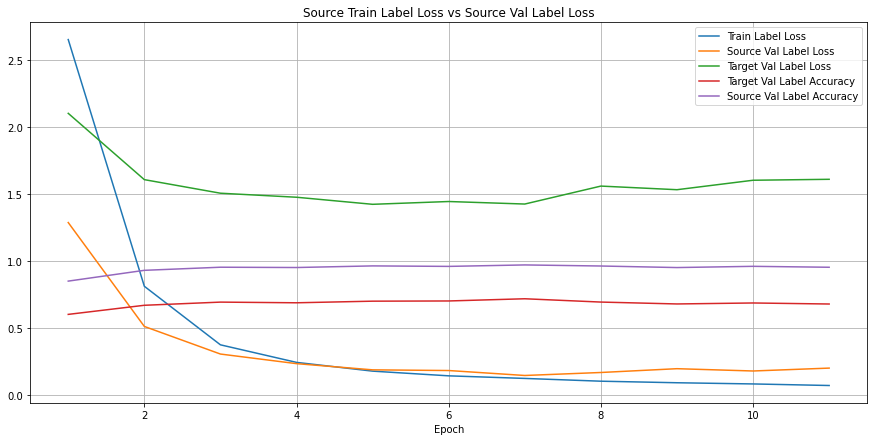

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

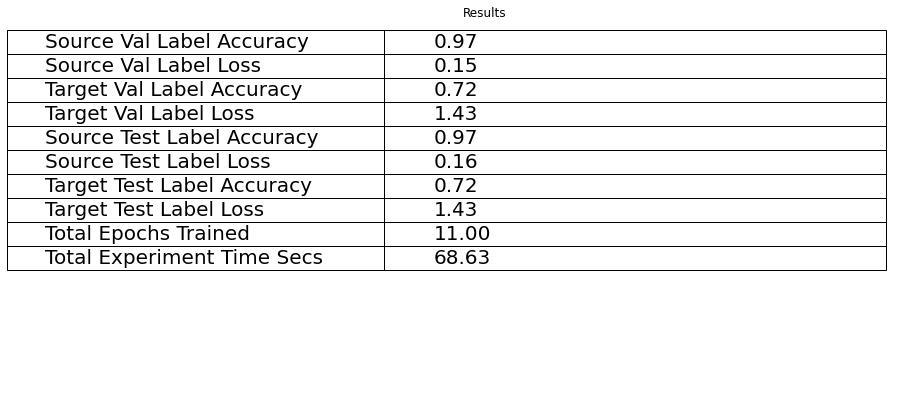

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

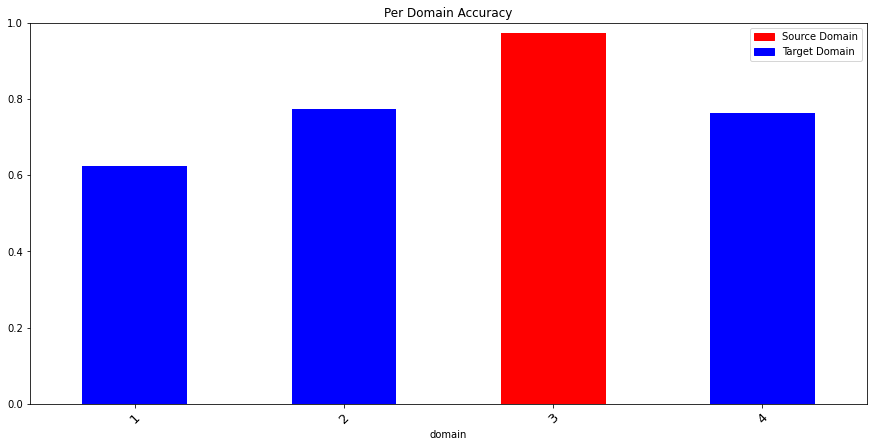

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9711046453295876 Target Test Label Accuracy: 0.7209040637860082
Source Val Label Accuracy: 0.9742331288343559 Target Val Label Accuracy: 0.7217752485609629


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_1:wisig", "parameters": {"experiment_name": "cnn_1:wisig", "labels": ["1-10", "1-12", "1-14", "1-16", "1-18", "1-19", "1-8", "10-11", "10-17", "10-4", "10-7", "11-1", "11-10", "11-19", "11-20", "11-4", "11-7", "12-19", "12-20", "12-7", "13-14", "13-18", "13-19", "13-20", "13-3", "13-7", "14-10", "14-11", "14-12", "14-13", "14-14", "14-19", "14-20", "14-7", "14-8", "14-9", "15-1", "15-19", "15-6", "16-1", "16-16", "16-19", "16-20", "17-10", "17-11", "18-1", "18-10", "18-11", "18-12", "18-13", "18-14", "18-15", "18-16", "18-17", "18-19", "18-2", "18-20", "18-4", "18-5", "18-7", "18-8", "18-9", "19-1", "19-10", "19-11", "19-12", "19-13", "19-14", "19-15", "19-19", "19-2", "19-20", "19-3", "19-4", "19-6", "19-7", "19-8", "19-9", "2-1", "2-13", "2-15", "2-3", "2-4", "2-5", "2-6", "2-7", "2-8", "20-1", "20-12", "20-14", "20-15", "20-16", "20-18", "20-19", "20-20", "20-3", "20-4", "20-5", "20-7", "20-8", "3-1", "3-13", "3-18", "3-2", "3-8", "4-1", "4-10", "4-11", "5-